# Experiment and path specification

In [4]:
# Specify the experiment for analysis
experiment='cxic00318'
runNumber = 123

# Set the installation and output path
import os
os.environ['INSTALLPATH']='/reg/neh/home/igabalsk/TRXS-Run18'
os.environ['OUTPUTPATH']= '/reg/d/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [5]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *

# Determine current user
currentUser, error = unixCMD("echo $USER")
currentUser = currentUser.strip()
print(currentUser)
os.environ['RESULTSPATH']= ('/reg/d/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

igabalsk


# Leveraging the batch queue to quickly grab point data

## Loading libraries

In [6]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsLibraries')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

## Grabbing point data across nodes

In [7]:

detDict = {'opaint':{'name':'XppEnds_Ipm0','get-function': 'getIPM' },
           'xint3':{'name':'XppSb3_Ipm','get-function': 'getIPM' },
           'xpos3':{'name':'XppSb3_Ipm','get-function': 'getXPos' },
           'ypos3':{'name':'XppSb3_Ipm','get-function': 'getYPos' },
           'xint2':{'name':'XppSb2_Ipm','get-function': 'getIPM' },
           'xpos2':{'name':'XppSb2_Ipm','get-function': 'getXPos' },
           'ypos2':{'name':'XppSb2_Ipm','get-function': 'getYPos' },
           'xrayEnergy':{'name':'SIOC:SYS0:ML00:AO541','get-function': 'getXrayEnergy' },
          'stageencoder':{'name':'XppEndstation.0:USDUSB.0','get-function':'getStageEncoder'},
          'ttfltpos':{'name':'XPP:TIMETOOL:FLTPOS', 'get-function': 'getTTFltPos'},
          'ebeamcharge':{'name':'EBeam', 'get-function': 'getEbeamCharge'},
          'fltposfwhm':{'name':'XPP:TIMETOOL:FLTPOSFWHM', 'get-function': 'getFltPosFWHM'},
          'seconds':{'name':'seconds', 'get-function': 'getSeconds'},
          'nanoseconds':{'name':'nanonseconds', 'get-function': 'getNanoseconds'},
          'fiducials':{'name':'fiducials', 'get-function': 'getFiducials'},
          'cspadSum':{'name':'fiducials', 'get-function': 'getCSPADsum'},
          'cspadMedian':{'name':'fiducials', 'get-function': 'getCSPADmedian'}}


batchThreads = batchPointDataGrabber( detDict, eventMax=1e5, experiment=experiment, runNumber=runNumber, rank=100 )
batchThreads.Queue = 'psanaq'
batchThreads.start()

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp0.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp0.py'
Output: Job <137097> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137097> is submitted to queue <psanaq>.

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp1.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp1.py'
Output: Job <137101> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137101> is submit

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp16.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp16.py'
Output: Job <137220> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137220> is submitted to queue <psanaq>.

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp17.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp17.py'
Output: Job <137229> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137229> is su

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp32.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp32.py'
Output: Job <137333> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137333> is submitted to queue <psanaq>.

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp33.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp33.py'
Output: Job <137343> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137343> is su

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp48.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp48.py'
Output: Job <137436> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137436> is submitted to queue <psanaq>.

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp49.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp49.py'
Output: Job <137439> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137439> is su

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp64.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp64.py'
Output: Job <137473> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137473> is submitted to queue <psanaq>.

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp65.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp65.py'
Output: Job <137480> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137480> is su

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run123-temp80.out /reg/neh/home/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run123-temp80.py'
Output: Job <137566> is submitted to queue <psanaq>.

Error: 
Heres the batch output  Job <137566> is submitted to queue <psanaq>.

Deleting the old output file ...
Output: 
Error: None


## Check job status

In [10]:
stdoutdata, stderrdata = bjobs()
print stdoutdata
print stderrdata


No unfinished job found



## Kill threads if they die

In [11]:
batchThreads.requestStop()
time.sleep(5)
bkill(killAll=True)

('', 'No unfinished job found\n')

In [12]:
batchThreads.status

'Gathering'

In [13]:
batchThreads.gather()

IOError: Did you load the correct file? /reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/nodePointDataGrabber0-run-123


IOError: [Errno 2] No such file or directory: '/reg/d/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/nodePointDataGrabber0-run-123.pkl'

## Drop empty array values

In [14]:
pointData = batchThreads.detArrays

def dropEmpty(pointData):

    filledBin = (pointData['seconds'] > 0)

    for key in pointData.keys():
        pointData[key]=pointData[key][filledBin] 
        
    return pointData

pointData = dropEmpty(pointData)


TypeError: 'NoneType' object has no attribute '__getitem__'

## Save point data

In [15]:
save_obj( pointData, os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )

## Plot histogram of result

TypeError: 'NoneType' object has no attribute '__getitem__'

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


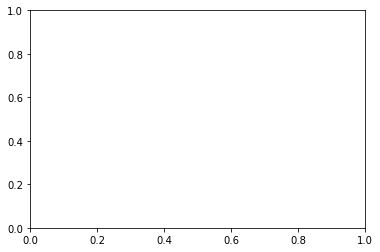

In [16]:
detArrays = pointData

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['ebeamcharge'], bins=100,normed=False, alpha=0.5);